<a href="https://colab.research.google.com/github/ZvoneST/pytorch-labs/blob/master/lovro_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
# Training settings
batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])
test_dataset = ImageFolder('lovro/', data_transforms)
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        #print(self.conv1.weight.shape)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=3)
       #print(self.conv2.weight.shape)
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(320, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.relu(self.mp(self.conv2(x)))
        x = F.relu(self.mp(self.conv3(x)))
        
        #print("2.", x.shape)
       # x = F.relu(self.mp(self.conv3(x)))
        x = x.view(in_size, -1)  # flatten the tensor
        #print("3.", x.shape)
        x = self.fc(x)
        return F.log_softmax(x)


model = Net()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
       # print(target, output)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).data
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, 2):
    train(epoch)
    test()
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model.pt') # Save

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298716
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.306512
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.293967
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.299939
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.303236
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.297542
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.303114
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.295347
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.296513
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.294319
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.288235
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.278487
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.271936
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.269166
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.268812
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.246056
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.221994
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.181587
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.123480
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.992912
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
test_loader.dataset

Dataset ImageFolder
    Number of datapoints: 11
    Root location: lovro/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [ ]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
imgs = torch.stack([img_t for img_t, _ in test_dataset], dim=1)
imgs.view(1, -1).mean(dim=1)

tensor([0.0858])

In [ ]:
imgs.view(1, -1).std(dim=1)

tensor([0.2801])

In [ ]:
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=1)
imgs.view(1, -1).mean(dim=1)

tensor([0.1307])

In [ ]:
imgs.view(1, -1).std(dim=1)

tensor([0.3081])

In [ ]:
max_degree=30
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.Compose([
                     transforms.RandomAffine((0, 10)),
                    transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                       # transforms.Normalize((0.1307,), (0.3081,))
                    

                                                            ]),
                               download=False)
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])
#test_dataset = ImageFolder('lovro/', data_transforms)
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

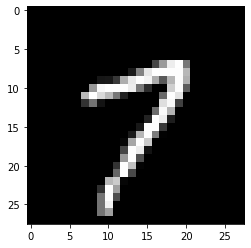

In [ ]:
imgs, lbls = next(iter(train_loader))
imgs[7].data.shape
plt.imshow(imgs[7].data.reshape((28,28)), cmap="gray")

In [ ]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
for epoch in range(1, 2):
    train(epoch)
    test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301778
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.299991
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.301777
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.306104
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.299685
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.292202
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.281761
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.288778
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.276872
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.272185
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.272032
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.272552
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.237378
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.202799
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.206467
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.107745
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.088117
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.863841
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.469635
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.191105
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## Data Augmentation / Image transformation 

A deep network requires extensive data to achieve decent performance. To build a good classifier with small training data, image augmentation can solve the problem to a greater extend. Image augmentation generates images by different ways of processing, such as random shift, rotation, flips, etc.

Below are the list of transformations that come pre-built with PyTorch:
- ToTensor
- ToPILImage
- Normalize
- Resize
- Scale
- CenterCrop
- Pad
- Lambda
- RandomApply
- RandomChoice
- RandomOrder
- RandomCrop
- RandomHorizontalFlip
- RandomVerticalFlip
- RandomResizedCrop
- RandomSizedCrop
- FiveCrop
- TenCrop
- LinearTransformation
- ColorJitter
- RandomRotation
- RandomAffine
- Grayscale
- RandomGrayscale
- RandomPerspective
- RandomErasing




##Ex 1 
Consider which of the following data augmentation are useful in increasing the correct algorithm on the drawn examples. Implement the selected functions and check that you have increased the accuracy of the algorithm.

In [ ]:
#your code

# Dropout
Yet another way to prevent overfitting is to build many models, then average their predictions at test time. Each model might have a different set of initial weights.

We won't show an example of model averaging here. Instead, we will show another idea that sounds drastically different on the surface.

This idea is called dropout: we will randomly "drop out", "zero out", or "remove" a portion of neurons from each training iteration.



In different iterations of training, we will drop out a different set of neurons.

The technique has an effect of preventing weights from being overly dependent on each other: for example for one weight to be unnecessarily large to compensate for another unnecessarily large weight with the opposite sign. Weights are encouraged to be "more independent" of one another.

During test time though, we will not drop out any neurons; instead we will use the entire set of weights. This means that our training time and test time behaviour of dropout layers are different. In the code for the function train and get_accuracy, we use model.train() and model.eval() to flag whether we want the model's training behaviour, or test time behaviour.

While unintuitive, using all connections is a form of model averaging! We are effectively averaging over many different networks of various connectivity structures.

In [ ]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])
test_dataset = ImageFolder('lovro/', data_transforms)
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        nn.Dropout(0.2)
        #print(self.conv1.weight.shape)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=3)
       #print(self.conv2.weight.shape)
        nn.Dropout(0.2)
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(320, 10)
        nn.Dropout(0.2)
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.relu(self.mp(self.conv2(x)))
        x = F.relu(self.mp(self.conv3(x)))
        
        #print("2.", x.shape)
       # x = F.relu(self.mp(self.conv3(x)))
        x = x.view(in_size, -1)  # flatten the tensor
        #print("3.", x.shape)
        x = self.fc(x)
        return F.log_softmax(x)


model = Net()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [ ]:
for epoch in range(1, 2):
    train(epoch)
    test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306096
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.303867
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.302498
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.296979
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.293898
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.296088
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.290628
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.290530
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.288451
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.279634
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.286249
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.282610
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.268640
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.257897
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.252043
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.266900
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.225874
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.206649
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.126844
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.980650
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Ex2  
Try to combine data augmentation and dropout idea and compare result of convolutional neural network.

In [ ]:
#your code

# Weight Decay
A more interesting technique that prevents overfitting is the idea of weight decay. The idea is to **penalize large weights**. We avoid large weights, because large weights mean that the prediction relies a lot on the content of one pixel, or on one unit. Intuitively, it does not make sense that the classification of an image should depend heavily on the content of one pixel, or even a few pixels.

Mathematically, we penalize large weights by adding an extra term to the loss function, the term can look like the following:<br>

*  $L^1$ regularization $\sum_{k} |w_k|$<br>
Mathematically, this term encourages weights to be exactly 0.<br><br>
*  $L^2$ regularization $\sum_{k} w_k^2$<br>
Mathematically, in each iteration the weight is pushed towards 0.<br><br>
*  Combination of $L^1$ and $L^2$ regularization: add a term  $\sum_{k} |w_k| + w_k^2$ to the loss function.





In PyTorch, weight decay can also be done automatically inside an optimizer. The parameter weight_decay of optim.SGD and most other optimizers uses  L2  regularization for weight decay. The value of the weight_decay parameter is another tunable hyperparameter.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5, weight_decay=1e-5)

# Ex3 
Try which combination of methods (or maybe all) makes the best possible result.

In [ ]:
#your code